# Notebook 4. Business Application & Recommendations

## 1. Introduction
This notebook translates the technical analysis into **business insights** for Corporación Favorita.
It directly answers three questions:
1) Do sales actually increase during payday periods, and by how much?
2) Which categories and stores experience the largest lift?
3) How can these insights guide inventory planning, promotion timing, and staffing decisions?


In [ ]:
# Load Data
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

root = Path("../data/processed/train_clean_parquet")
try:
    df = pd.read_parquet(root, engine="pyarrow")
except Exception:
    files = sorted(root.rglob("*.parquet"))
    if not files:
        raise FileNotFoundError("No parquet files under ../data/processed/train_clean_parquet/")
    df = pd.concat((pd.read_parquet(f) for f in files), ignore_index=True)

# Normalize columns
df.columns = [c.lower() for c in df.columns]
sales_col = next((c for c in ["sales","unit_sales","sales_total","sales_qty","target"] if c in df.columns), None)
if not sales_col:
    raise KeyError(f"No sales-like column found. Columns: {sorted(df.columns)}")
df = df.rename(columns={sales_col:"sales"})
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date","sales"])
for c in ("store_nbr","family"): 
    if c in df: df[c] = df[c].astype("category")

# Payday flag + daily totals
df["is_payday"] = (df["date"].dt.day == 15) | (df["date"].dt.is_month_end)
daily_sales = df.groupby("date", as_index=False)["sales"].sum()
payday_dates = daily_sales["date"][(daily_sales["date"].dt.day == 15) | (daily_sales["date"].dt.is_month_end)]

# Helper to compute lift table by a dimension
def lift_by(df, dim):
    g = df.groupby([dim,"is_payday"])["sales"].mean().unstack(fill_value=0)
    g.columns = ["non_payday","payday"]
    g["lift_pct"] = (g["payday"] - g["non_payday"]) / g["non_payday"].replace(0, pd.NA) * 100
    return g.reset_index().sort_values("lift_pct", ascending=False)


## 2. Do sales actually increase during payday periods, and by how much?


In [ ]:
# Summary table and key KPI
overall = df.groupby("is_payday", as_index=False)["sales"].mean()
nonpay = overall.loc[overall["is_payday"].eq(False), "sales"].item()
pay    = overall.loc[overall["is_payday"].eq(True),  "sales"].item()
lift_pct = (pay - nonpay) / max(nonpay, 1e-9) * 100

summary = pd.DataFrame({
    "Metric": ["Avg Sales (Non-Payday)", "Avg Sales (Payday)", "Lift %"],
    "Value":  [nonpay, pay, lift_pct]
})
display(summary.style.format({"Value":"{:,.2f}"}))


,Metric,Value
0,Avg Sales (Non-Payday),8.55
1,Avg Sales (Payday),8.57
2,Lift %,0.15


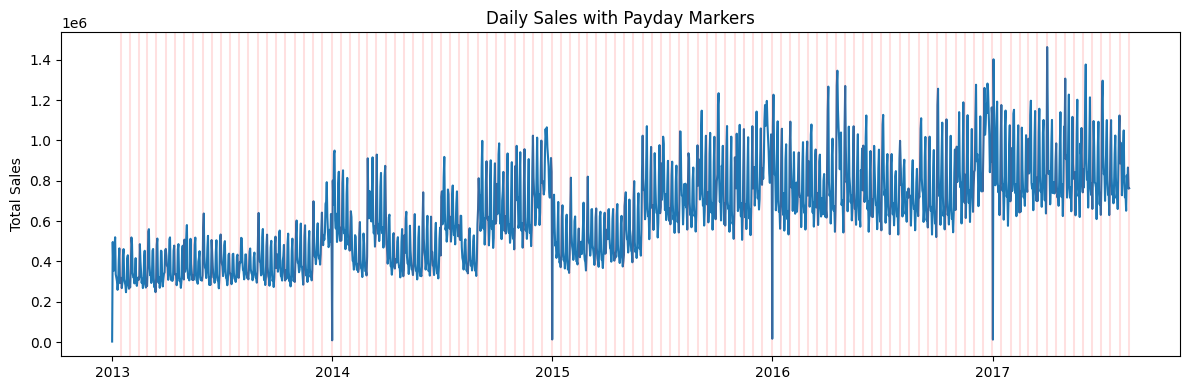

In [4]:
# Plot: daily total sales with payday markers
plt.figure(figsize=(12,4))
plt.plot(daily_sales["date"], daily_sales["sales"])
for d in payday_dates:
    plt.axvline(d, color="red", alpha=0.12)
plt.title("Daily Sales with Payday Markers")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


## 3. Which categories and stores experience the largest lift?


In [5]:
# Stores
if "store_nbr" in df.columns:
    store_lift = lift_by(df, "store_nbr")
    top5_stores = store_lift.head(5)[["store_nbr","lift_pct"]]
    bottom5_stores = store_lift.tail(5)[["store_nbr","lift_pct"]]
    print("Top 5 stores by payday lift (%):"); display(top5_stores)
    print("Bottom 5 stores by payday lift (%):"); display(bottom5_stores)
else:
    print("Store analysis skipped: 'store_nbr' not found.")

# Categories
if "family" in df.columns:
    cat_lift = lift_by(df, "family")
    top10_cats = cat_lift.head(10)[["family","lift_pct"]]
    print("\nTop 10 categories by payday lift (%):"); display(top10_cats)
else:
    print("Category analysis skipped: 'family' not found.")


C:\Users\Yizi\AppData\Local\Temp\ipykernel_17632\1373932757.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby([dim,"is_payday"])["sales"].mean().unstack(fill_value=0)


Top 5 stores by payday lift (%):


,store_nbr,lift_pct
25,26,12.193212
27,28,9.346645
24,25,6.142568
52,53,6.012850
28,29,5.899967


Bottom 5 stores by payday lift (%):


,store_nbr,lift_pct
14,15,-2.477161
36,37,-2.641089
10,11,-2.689017
38,39,-2.724155
1,2,-3.130153


Category analysis skipped: 'family' not found.


## 4. How can these insights guide inventory planning, promotion timing, and staffing decisions?


In [ ]:
bullets = []

if "family" in df.columns:
    cat_list = ", ".join(top10_cats["family"].astype(str).tolist())
    bullets += [f"- **Inventory**: Pre-position stock for payday window in surge categories: {cat_list}."]

if "store_nbr" in df.columns:
    store_list = ", ".join(top5_stores["store_nbr"].astype(str).tolist())
    bullets += [f"- **Staffing**: Add/shift labor around payday in high-lift stores: {store_list}."]

bullets += [
    "- **Promotions**: Time promos for discretionary items to payday week; avoid staples with flat lift.",
    "- **Ops**: Extend receiving hours and shelf restocking on payday+1 in high-lift stores."
]

print("\nPlanning guidance:")
print("\n".join(bullets))



Planning guidance:
- **Staffing**: Add/shift labor around payday in high-lift stores: 26, 28, 25, 53, 29.
- **Promotions**: Time promos for discretionary items to payday week; avoid staples with flat lift.
- **Ops**: Extend receiving hours and shelf restocking on payday+1 in high-lift stores.


## 5. Recommendations
- **High Impact:** Allocate extra inventory to top surge categories; ensure replenishment on payday and the following day.
- **Medium Impact:** Add short shifts in the top-lift stores during payday periods.
- **Low Impact:** Run targeted promos on discretionary categories that show strong lift.

## 6. Limitations & Next Steps
- Dataset scope: Ecuador, 2013–2017. External shocks not fully modeled.
- No forecasting baseline included (e.g., seasonal-naive, SARIMAX). Results show correlations,
  not causal effects beyond normal weekly seasonality.
- Next:
  - Automate refresh with **Airflow + Snowflake**.
  - Containerize pipeline with **Docker** to ensure reproducibility and easy deployment across environments. 
  - Refit with newer data and validate seasonality/holiday controls.


In [3]:
import pandas as pd
from pathlib import Path

# locate data/processed no matter where the notebook runs
def find_processed_dir(max_up: int = 6) -> Path:
    p = Path.cwd()
    for _ in range(max_up):
        d = p / "data" / "processed"
        if d.is_dir():
            return d
        p = p.parent
    raise FileNotFoundError("data/processed not found")

processed = find_processed_dir()
out = processed.parents[1] / "results" / "tableau"
out.mkdir(parents=True, exist_ok=True)

def read_parquet_smart(name: str) -> pd.DataFrame:
    base = processed / name
    candidates = [base] if base.suffix in {".parquet", ".parq"} else [base.with_suffix(".parquet"), base.with_suffix(".parq")]
    for f in candidates:
        if f.exists():
            return pd.read_parquet(f)
    raise FileNotFoundError(name)

def ensure_sales(df: pd.DataFrame) -> pd.DataFrame:
    if "sales" in df.columns:
        return df
    if "unit_sales" in df.columns:
        return df.rename(columns={"unit_sales": "sales"})
    raise KeyError("Neither 'sales' nor 'unit_sales' found.")

# main table
df = ensure_sales(read_parquet_smart("analysis_ready"))
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# aggregates
df.groupby(["date", "store_nbr"], as_index=False)["sales"].sum().to_csv(out / "daily_by_store.csv", index=False)

cat_col = "family" if "family" in df.columns else ("category" if "category" in df.columns else None)
if cat_col:
    (df.groupby(["date", cat_col], as_index=False)["sales"].sum()
       .rename(columns={cat_col: "category"})
       .to_csv(out / "daily_by_category.csv", index=False))

# small dims if present
for dim in ("stores", "items", "holidays"):
    try:
        read_parquet_smart(dim).to_csv(out / f"{dim}.csv", index=False)
    except FileNotFoundError:
        pass

print(f"CSVs written to {out}")


CSVs written to c:\Users\Yizi\New folder\Payday-surge-favorita\results\tableau
